# Main Project

## Project Goals
- Utilize machine learning methods to calibrate data from the Quant-Aq Pm modular air-quality sensors with the gas-outdoor sensor with the purpose of being able to deploy the modular-PM air quality sensor at different locations and obtain trustworthy measurements under different parameters such as temperature and relative humidity
- Prediction analysis
- Evaluate the performance of the different models

### Approach
- Simple Linear Regression
- Multilinear Regression
- RandomForest
- Xgboost

Choice of approach was based on the data we are working with, in this we are trying to predict continuous outputs. Regression task is best suited, and we can evaluate with a simple linear or multilinear regression, other models like randomForest and Xgboost can be used on regression tasks as well as classification tasks. 

## Data Preparation
Data was downloaded from the installed Quant-AQ air quality senors in 3101 Market st, Philadelphia. Here we evaluated data from the first three weeks in October.

In [44]:
#Loading necessary libraries
import pandas as pd
import numpy as np
from plotnine import ggplot, aes, geom_bar, theme_minimal, labs
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.optimize import curve_fit
import scipy.stats as stats
from datetime import datetime
from matplotlib.dates import DateFormatter
import warnings

In [45]:
#hide warnings:
warnings.filterwarnings("ignore")

In [46]:
#Loading the data
dfMod = pd.read_csv('October_data/outdoor.csv',parse_dates=['timestamp_local'],index_col='timestamp_local') #timestamp_local parsed as a datetime object
dfAlp = pd.read_csv('October_data/alpha.csv',parse_dates=['timestamp_local'],index_col='timestamp_local')
dfBet = pd.read_csv('October_data/beta.csv',parse_dates=['timestamp_local'],index_col='timestamp_local')

Observing the dataframes:

In [47]:
# For the outdoor gas sensor
dfMod

timestamp         sn    rh  temp  \
timestamp_local                                                          
2023-10-21 19:59:30+00:00  2023-10-21T23:59:30Z  MOD-00353  37.5  26.5   
2023-10-21 19:58:30+00:00  2023-10-21T23:58:30Z  MOD-00353  37.5  26.5   
2023-10-21 19:57:30+00:00  2023-10-21T23:57:30Z  MOD-00353  37.6  26.6   
2023-10-21 19:56:30+00:00  2023-10-21T23:56:30Z  MOD-00353  37.5  26.6   
2023-10-21 19:55:30+00:00  2023-10-21T23:55:30Z  MOD-00353  37.6  26.6   
...                                         ...        ...   ...   ...   
2023-09-30 20:04:35+00:00  2023-10-01T00:04:35Z  MOD-00353  54.1  24.9   
2023-09-30 20:03:35+00:00  2023-10-01T00:03:35Z  MOD-00353  54.1  24.9   
2023-09-30 20:02:35+00:00  2023-10-01T00:02:35Z  MOD-00353  54.1  24.9   
2023-09-30 20:01:35+00:00  2023-10-01T00:01:35Z  MOD-00353  54.1  24.9   
2023-09-30 20:00:35+00:00  2023-10-01T00:00:35Z  MOD-00353  54.1  24.9   

                               lat       lon device_state    pm1   pm25  \
timestamp_local                                                           
2023-10-21 19:59:30+00:00  39.9559 -75.18598       ACTIVE  1.041  1.051   
2023-10-21 19:58:30+00:00  39.9559 -75.18598       ACTIVE  0.723  0.780   
2023-10-21 19:57:30+00:00  39.9559 -75.18598       ACTIVE  0.825  0.887   
2023-10-21 19:56:30+00:00  39.9559 -75.18598       ACTIVE  1.046  1.049   
2023-10-21 19:55:30+00:00  39.9559 -75.18598       ACTIVE  1.077  1.089   
...                            ...       ...          ...    ...    ...   
2023-09-30 20:04:35+00:00  39.9559 -75.18598       ACTIVE  1.420  1.431   
2023-09-30 20:03:35+00:00  39.9559 -75.18598       ACTIVE  1.600  1.610   
2023-09-30 20:02:35+00:00  39.9559 -75.18598       ACTIVE  1.370  1.375   
2023-09-30 20:01:35+00:00  39.9559 -75.18598       ACTIVE  1.643  1.645   
2023-09-30 20:00:35+00:00  39.9559 -75.18598       ACTIVE  1.663  1.671   

                            pm10       co     no     no2      o3  co2  
timestamp_local                                                        
2023-10-21 19:59:30+00:00  1.051  437.483  4.193   7.492  22.188  NaN  
2023-10-21 19:58:30+00:00  0.835  437.894  4.191   7.608  21.650  NaN  
2023-10-21 19:57:30+00:00  0.887  431.363  4.181   8.629  21.905  NaN  
2023-10-21 19:56:30+00:00  1.049  434.718  4.181   7.546  21.670  NaN  
2023-10-21 19:55:30+00:00  1.089  435.878  4.179   8.745  22.443  NaN  
...                          ...      ...    ...     ...     ...  ...  
2023-09-30 20:04:35+00:00  1.431  509.354  2.510  17.247  13.697  NaN  
2023-09-30 20:03:35+00:00  1.610  517.153  2.511  12.034  13.697  NaN  
2023-09-30 20:02:35+00:00  1.375  510.585  2.509  12.034  12.792  NaN  
2023-09-30 20:01:35+00:00  1.645  507.711  2.511  17.247  13.697  NaN  
2023-09-30 20:00:35+00:00  1.671  510.996  2.508  12.034  13.395  NaN  

[28439 rows x 15 columns]

In [48]:
# For the alpha sensor
dfAlp

timestamp         id            sn  \
timestamp_local                                                            
2023-10-21 19:59:22+00:00  2023-10-21T23:59:22Z  398412296  MOD-PM-00955   
2023-10-21 19:58:22+00:00  2023-10-21T23:58:22Z  398412294  MOD-PM-00955   
2023-10-21 19:57:22+00:00  2023-10-21T23:57:22Z  398412295  MOD-PM-00955   
2023-10-21 19:56:22+00:00  2023-10-21T23:56:22Z  398408669  MOD-PM-00955   
2023-10-21 19:55:22+00:00  2023-10-21T23:55:22Z  398408668  MOD-PM-00955   
...                                         ...        ...           ...   
2023-09-30 20:04:28+00:00  2023-10-01T00:04:28Z  384933350  MOD-PM-00955   
2023-09-30 20:03:28+00:00  2023-10-01T00:03:28Z  384933345  MOD-PM-00955   
2023-09-30 20:02:28+00:00  2023-10-01T00:02:28Z  384933349  MOD-PM-00955   
2023-09-30 20:01:28+00:00  2023-10-01T00:01:28Z  384933348  MOD-PM-00955   
2023-09-30 20:00:28+00:00  2023-10-01T00:00:28Z  384933347  MOD-PM-00955   

                           sample_rh  sample_temp  sample_pres     lat  \
timestamp_local                                                          
2023-10-21 19:59:22+00:00      37.98        26.11          0.0  39.956   
2023-10-21 19:58:22+00:00      37.95        26.09          0.0  39.956   
2023-10-21 19:57:22+00:00      37.95        26.10          0.0  39.956   
2023-10-21 19:56:22+00:00      37.98        26.10          0.0  39.956   
2023-10-21 19:55:22+00:00      38.01        26.10          0.0  39.956   
...                              ...          ...          ...     ...   
2023-09-30 20:04:28+00:00      54.70        24.45          0.0  39.956   
2023-09-30 20:03:28+00:00      54.71        24.44          0.0  39.956   
2023-09-30 20:02:28+00:00      54.71        24.44          0.0  39.956   
2023-09-30 20:01:28+00:00      54.71        24.44          0.0  39.956   
2023-09-30 20:00:28+00:00      54.70        24.44          0.0  39.956   

                              lon device_state    pm1   pm25   pm10  \
timestamp_local                                                       
2023-10-21 19:59:22+00:00 -75.186       ACTIVE  0.793  0.857  1.650   
2023-10-21 19:58:22+00:00 -75.186       ACTIVE  0.836  0.840  0.840   
2023-10-21 19:57:22+00:00 -75.186       ACTIVE  1.001  1.005  1.005   
2023-10-21 19:56:22+00:00 -75.186       ACTIVE  0.681  0.725  0.725   
2023-10-21 19:55:22+00:00 -75.186       ACTIVE  0.724  0.799  0.799   
...                           ...          ...    ...    ...    ...   
2023-09-30 20:04:28+00:00 -75.186       ACTIVE  1.488  1.527  1.527   
2023-09-30 20:03:28+00:00 -75.186       ACTIVE  1.312  1.324  1.324   
2023-09-30 20:02:28+00:00 -75.186       ACTIVE  1.736  1.771  1.771   
2023-09-30 20:01:28+00:00 -75.186       ACTIVE  1.553  1.575  1.575   
2023-09-30 20:00:28+00:00 -75.186       ACTIVE  1.414  1.440  1.440   

                           pm1_model_id  pm25_model_id  pm10_model_id  
timestamp_local                                                        
2023-10-21 19:59:22+00:00        8520.0         8521.0         8522.0  
2023-10-21 19:58:22+00:00        8520.0         8521.0         8522.0  
2023-10-21 19:57:22+00:00        8520.0         8521.0         8522.0  
2023-10-21 19:56:22+00:00        8520.0         8521.0         8522.0  
2023-10-21 19:55:22+00:00        8520.0         8521.0         8522.0  
...                                 ...            ...            ...  
2023-09-30 20:04:28+00:00        8520.0         8521.0         8522.0  
2023-09-30 20:03:28+00:00        8520.0         8521.0         8522.0  
2023-09-30 20:02:28+00:00        8520.0         8521.0         8522.0  
2023-09-30 20:01:28+00:00        8520.0         8521.0         8522.0  
2023-09-30 20:00:28+00:00        8520.0         8521.0         8522.0  

[30088 rows x 15 columns]

In [49]:
# For the beta sensor
dfBet

timestamp         id            sn  \
timestamp_local                                                            
2023-10-21 19:59:13+00:00  2023-10-21T23:59:13Z  398411737  MOD-PM-00954   
2023-10-21 19:58:13+00:00  2023-10-21T23:58:13Z  398411735  MOD-PM-00954   
2023-10-21 19:57:13+00:00  2023-10-21T23:57:13Z  398411733  MOD-PM-00954   
2023-10-21 19:56:13+00:00  2023-10-21T23:56:13Z  398408600  MOD-PM-00954   
2023-10-21 19:55:13+00:00  2023-10-21T23:55:13Z  398408601  MOD-PM-00954   
...                                         ...        ...           ...   
2023-09-30 20:04:17+00:00  2023-10-01T00:04:17Z  384932834  MOD-PM-00954   
2023-09-30 20:03:17+00:00  2023-10-01T00:03:17Z  384932832  MOD-PM-00954   
2023-09-30 20:02:17+00:00  2023-10-01T00:02:17Z  384932828  MOD-PM-00954   
2023-09-30 20:01:17+00:00  2023-10-01T00:01:17Z  384932829  MOD-PM-00954   
2023-09-30 20:00:17+00:00  2023-10-01T00:00:17Z  384932831  MOD-PM-00954   

                           sample_rh  sample_temp  sample_pres     lat  \
timestamp_local                                                          
2023-10-21 19:59:13+00:00      37.97        26.04          0.0  39.956   
2023-10-21 19:58:13+00:00      37.96        26.04          0.0  39.956   
2023-10-21 19:57:13+00:00      37.98        26.04          0.0  39.956   
2023-10-21 19:56:13+00:00      37.99        26.04          0.0  39.956   
2023-10-21 19:55:13+00:00      38.02        26.03          0.0  39.956   
...                              ...          ...          ...     ...   
2023-09-30 20:04:17+00:00      54.66        24.38          0.0  39.956   
2023-09-30 20:03:17+00:00      54.66        24.38          0.0  39.956   
2023-09-30 20:02:17+00:00      54.67        24.38          0.0  39.956   
2023-09-30 20:01:17+00:00      54.67        24.38          0.0  39.956   
2023-09-30 20:00:17+00:00      54.68        24.38          0.0  39.956   

                              lon device_state    pm1   pm25   pm10  \
timestamp_local                                                       
2023-10-21 19:59:13+00:00 -75.186       ACTIVE  0.917  0.928  0.928   
2023-10-21 19:58:13+00:00 -75.186       ACTIVE  0.889  0.903  0.903   
2023-10-21 19:57:13+00:00 -75.186       ACTIVE  0.703  0.772  0.772   
2023-10-21 19:56:13+00:00 -75.186       ACTIVE  1.345  1.367  1.367   
2023-10-21 19:55:13+00:00 -75.186       ACTIVE  0.571  0.659  0.905   
...                           ...          ...    ...    ...    ...   
2023-09-30 20:04:17+00:00 -75.186       ACTIVE  1.858  1.862  1.862   
2023-09-30 20:03:17+00:00 -75.186       ACTIVE  1.264  1.296  1.296   
2023-09-30 20:02:17+00:00 -75.186       ACTIVE  1.682  1.685  1.685   
2023-09-30 20:01:17+00:00 -75.186       ACTIVE  1.115  1.154  1.154   
2023-09-30 20:00:17+00:00 -75.186       ACTIVE  1.558  1.578  1.578   

                           pm1_model_id  pm25_model_id  pm10_model_id  
timestamp_local                                                        
2023-10-21 19:59:13+00:00        8517.0         8518.0         8519.0  
2023-10-21 19:58:13+00:00        8517.0         8518.0         8519.0  
2023-10-21 19:57:13+00:00        8517.0         8518.0         8519.0  
2023-10-21 19:56:13+00:00        8517.0         8518.0         8519.0  
2023-10-21 19:55:13+00:00        8517.0         8518.0         8519.0  
...                                 ...            ...            ...  
2023-09-30 20:04:17+00:00        8517.0         8518.0         8519.0  
2023-09-30 20:03:17+00:00        8517.0         8518.0         8519.0  
2023-09-30 20:02:17+00:00        8517.0         8518.0         8519.0  
2023-09-30 20:01:17+00:00        8517.0         8518.0         8519.0  
2023-09-30 20:00:17+00:00        8517.0         8518.0         8519.0  

[30083 rows x 15 columns]

The alpha and beta sensors have different names for the Relative humidity and temperature, we want this to be the same:

In [50]:
#Renaming columns:
dfAlp.rename(columns={'sample_rh':'rh'},inplace=True)
dfBet.rename(columns={'sample_rh':'rh'},inplace=True)
dfAlp.rename(columns={'sample_temp':'temp'},inplace=True)
dfBet.rename(columns={'sample_temp':'temp'},inplace=True)
dfAlp

timestamp         id            sn  \
timestamp_local                                                            
2023-10-21 19:59:22+00:00  2023-10-21T23:59:22Z  398412296  MOD-PM-00955   
2023-10-21 19:58:22+00:00  2023-10-21T23:58:22Z  398412294  MOD-PM-00955   
2023-10-21 19:57:22+00:00  2023-10-21T23:57:22Z  398412295  MOD-PM-00955   
2023-10-21 19:56:22+00:00  2023-10-21T23:56:22Z  398408669  MOD-PM-00955   
2023-10-21 19:55:22+00:00  2023-10-21T23:55:22Z  398408668  MOD-PM-00955   
...                                         ...        ...           ...   
2023-09-30 20:04:28+00:00  2023-10-01T00:04:28Z  384933350  MOD-PM-00955   
2023-09-30 20:03:28+00:00  2023-10-01T00:03:28Z  384933345  MOD-PM-00955   
2023-09-30 20:02:28+00:00  2023-10-01T00:02:28Z  384933349  MOD-PM-00955   
2023-09-30 20:01:28+00:00  2023-10-01T00:01:28Z  384933348  MOD-PM-00955   
2023-09-30 20:00:28+00:00  2023-10-01T00:00:28Z  384933347  MOD-PM-00955   

                              rh   temp  sample_pres     lat     lon  \
timestamp_local                                                        
2023-10-21 19:59:22+00:00  37.98  26.11          0.0  39.956 -75.186   
2023-10-21 19:58:22+00:00  37.95  26.09          0.0  39.956 -75.186   
2023-10-21 19:57:22+00:00  37.95  26.10          0.0  39.956 -75.186   
2023-10-21 19:56:22+00:00  37.98  26.10          0.0  39.956 -75.186   
2023-10-21 19:55:22+00:00  38.01  26.10          0.0  39.956 -75.186   
...                          ...    ...          ...     ...     ...   
2023-09-30 20:04:28+00:00  54.70  24.45          0.0  39.956 -75.186   
2023-09-30 20:03:28+00:00  54.71  24.44          0.0  39.956 -75.186   
2023-09-30 20:02:28+00:00  54.71  24.44          0.0  39.956 -75.186   
2023-09-30 20:01:28+00:00  54.71  24.44          0.0  39.956 -75.186   
2023-09-30 20:00:28+00:00  54.70  24.44          0.0  39.956 -75.186   

                          device_state    pm1   pm25   pm10  pm1_model_id  \
timestamp_local                                                             
2023-10-21 19:59:22+00:00       ACTIVE  0.793  0.857  1.650        8520.0   
2023-10-21 19:58:22+00:00       ACTIVE  0.836  0.840  0.840        8520.0   
2023-10-21 19:57:22+00:00       ACTIVE  1.001  1.005  1.005        8520.0   
2023-10-21 19:56:22+00:00       ACTIVE  0.681  0.725  0.725        8520.0   
2023-10-21 19:55:22+00:00       ACTIVE  0.724  0.799  0.799        8520.0   
...                                ...    ...    ...    ...           ...   
2023-09-30 20:04:28+00:00       ACTIVE  1.488  1.527  1.527        8520.0   
2023-09-30 20:03:28+00:00       ACTIVE  1.312  1.324  1.324        8520.0   
2023-09-30 20:02:28+00:00       ACTIVE  1.736  1.771  1.771        8520.0   
2023-09-30 20:01:28+00:00       ACTIVE  1.553  1.575  1.575        8520.0   
2023-09-30 20:00:28+00:00       ACTIVE  1.414  1.440  1.440        8520.0   

                           pm25_model_id  pm10_model_id  
timestamp_local                                          
2023-10-21 19:59:22+00:00         8521.0         8522.0  
2023-10-21 19:58:22+00:00         8521.0         8522.0  
2023-10-21 19:57:22+00:00         8521.0         8522.0  
2023-10-21 19:56:22+00:00         8521.0         8522.0  
2023-10-21 19:55:22+00:00         8521.0         8522.0  
...                                  ...            ...  
2023-09-30 20:04:28+00:00         8521.0         8522.0  
2023-09-30 20:03:28+00:00         8521.0         8522.0  
2023-09-30 20:02:28+00:00         8521.0         8522.0  
2023-09-30 20:01:28+00:00         8521.0         8522.0  
2023-09-30 20:00:28+00:00         8521.0         8522.0  

[30088 rows x 15 columns]

Also need to reset the seconds component to 0 for the time based index since the data obtains 1min average concentrations for each row.

In [51]:
dfMod.index = dfMod.index.map(lambda x: x.replace(second=0))
dfAlp.index = dfAlp.index.map(lambda x: x.replace(second=0))
dfBet.index = dfBet.index.map(lambda x: x.replace(second=0))
dfAlp

timestamp         id            sn  \
timestamp_local                                                            
2023-10-21 19:59:00+00:00  2023-10-21T23:59:22Z  398412296  MOD-PM-00955   
2023-10-21 19:58:00+00:00  2023-10-21T23:58:22Z  398412294  MOD-PM-00955   
2023-10-21 19:57:00+00:00  2023-10-21T23:57:22Z  398412295  MOD-PM-00955   
2023-10-21 19:56:00+00:00  2023-10-21T23:56:22Z  398408669  MOD-PM-00955   
2023-10-21 19:55:00+00:00  2023-10-21T23:55:22Z  398408668  MOD-PM-00955   
...                                         ...        ...           ...   
2023-09-30 20:04:00+00:00  2023-10-01T00:04:28Z  384933350  MOD-PM-00955   
2023-09-30 20:03:00+00:00  2023-10-01T00:03:28Z  384933345  MOD-PM-00955   
2023-09-30 20:02:00+00:00  2023-10-01T00:02:28Z  384933349  MOD-PM-00955   
2023-09-30 20:01:00+00:00  2023-10-01T00:01:28Z  384933348  MOD-PM-00955   
2023-09-30 20:00:00+00:00  2023-10-01T00:00:28Z  384933347  MOD-PM-00955   

                              rh   temp  sample_pres     lat     lon  \
timestamp_local                                                        
2023-10-21 19:59:00+00:00  37.98  26.11          0.0  39.956 -75.186   
2023-10-21 19:58:00+00:00  37.95  26.09          0.0  39.956 -75.186   
2023-10-21 19:57:00+00:00  37.95  26.10          0.0  39.956 -75.186   
2023-10-21 19:56:00+00:00  37.98  26.10          0.0  39.956 -75.186   
2023-10-21 19:55:00+00:00  38.01  26.10          0.0  39.956 -75.186   
...                          ...    ...          ...     ...     ...   
2023-09-30 20:04:00+00:00  54.70  24.45          0.0  39.956 -75.186   
2023-09-30 20:03:00+00:00  54.71  24.44          0.0  39.956 -75.186   
2023-09-30 20:02:00+00:00  54.71  24.44          0.0  39.956 -75.186   
2023-09-30 20:01:00+00:00  54.71  24.44          0.0  39.956 -75.186   
2023-09-30 20:00:00+00:00  54.70  24.44          0.0  39.956 -75.186   

                          device_state    pm1   pm25   pm10  pm1_model_id  \
timestamp_local                                                             
2023-10-21 19:59:00+00:00       ACTIVE  0.793  0.857  1.650        8520.0   
2023-10-21 19:58:00+00:00       ACTIVE  0.836  0.840  0.840        8520.0   
2023-10-21 19:57:00+00:00       ACTIVE  1.001  1.005  1.005        8520.0   
2023-10-21 19:56:00+00:00       ACTIVE  0.681  0.725  0.725        8520.0   
2023-10-21 19:55:00+00:00       ACTIVE  0.724  0.799  0.799        8520.0   
...                                ...    ...    ...    ...           ...   
2023-09-30 20:04:00+00:00       ACTIVE  1.488  1.527  1.527        8520.0   
2023-09-30 20:03:00+00:00       ACTIVE  1.312  1.324  1.324        8520.0   
2023-09-30 20:02:00+00:00       ACTIVE  1.736  1.771  1.771        8520.0   
2023-09-30 20:01:00+00:00       ACTIVE  1.553  1.575  1.575        8520.0   
2023-09-30 20:00:00+00:00       ACTIVE  1.414  1.440  1.440        8520.0   

                           pm25_model_id  pm10_model_id  
timestamp_local                                          
2023-10-21 19:59:00+00:00         8521.0         8522.0  
2023-10-21 19:58:00+00:00         8521.0         8522.0  
2023-10-21 19:57:00+00:00         8521.0         8522.0  
2023-10-21 19:56:00+00:00         8521.0         8522.0  
2023-10-21 19:55:00+00:00         8521.0         8522.0  
...                                  ...            ...  
2023-09-30 20:04:00+00:00         8521.0         8522.0  
2023-09-30 20:03:00+00:00         8521.0         8522.0  
2023-09-30 20:02:00+00:00         8521.0         8522.0  
2023-09-30 20:01:00+00:00         8521.0         8522.0  
2023-09-30 20:00:00+00:00         8521.0         8522.0  

[30088 rows x 15 columns]

In performing a Regression, we first need a train-test split, and also to evaluate the model. A few things to note, first, the datetime column is in reverse order. Since we are working with three datasets, and we want to calibrate alpha to outdoor sensor and beta to outdoor sensor, we need pick the commmon timesteps accross the datasets should there be missing values in readings apparent with the different number of rows for each dataset. We also need to check for null values in the relevant parameters.
Preparing a train-test split with 20% test data:

In [52]:
dfMod.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 28439 entries, 2023-10-21 19:59:00+00:00 to 2023-09-30 20:00:00+00:00
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   timestamp     28439 non-null  object 
 1   sn            28439 non-null  object 
 2   rh            28439 non-null  float64
 3   temp          28439 non-null  float64
 4   lat           28439 non-null  float64
 5   lon           28439 non-null  float64
 6   device_state  28439 non-null  object 
 7   pm1           28438 non-null  float64
 8   pm25          28438 non-null  float64
 9   pm10          28438 non-null  float64
 10  co            28399 non-null  float64
 11  no            28399 non-null  float64
 12  no2           28399 non-null  float64
 13  o3            28399 non-null  float64
 14  co2           0 non-null      float64
dtypes: float64(12), object(3)
memory usage: 3.5+ MB


PM1, PM25 and PM10 have a null row, we will drop this row before performing analysis

In [53]:
columns_to_check = ['pm1', 'pm25', 'pm10']
#Drop the null rows
dfMod = dfMod.dropna(subset=columns_to_check)
dfAlp = dfAlp.dropna(subset=columns_to_check)
dfBet = dfBet.dropna(subset=columns_to_check)
print(len(dfMod), len(dfAlp), len(dfBet))
dfAlp.info()

28438 30087 30078
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30087 entries, 2023-10-21 19:59:00+00:00 to 2023-09-30 20:00:00+00:00
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   timestamp      30087 non-null  object 
 1   id             30087 non-null  int64  
 2   sn             30087 non-null  object 
 3   rh             30087 non-null  float64
 4   temp           30087 non-null  float64
 5   sample_pres    30087 non-null  float64
 6   lat            30087 non-null  float64
 7   lon            30087 non-null  float64
 8   device_state   30087 non-null  object 
 9   pm1            30087 non-null  float64
 10  pm25           30087 non-null  float64
 11  pm10           30087 non-null  float64
 12  pm1_model_id   30087 non-null  float64
 13  pm25_model_id  30087 non-null  float64
 14  pm10_model_id  30087 non-null  float64
dtypes: float64(11), int64(1), object(3)
memory usage: 3.7+ MB


In [54]:
# def remove_outliers(df, column_name):
#     # Calculate the mean of the column
#     mean_value = df[column_name].mean()

#     # Define the upper threshold (4 to 5 times the mean)
#     upper_threshold =40 * mean_value

#     # Filter the data and keep only rows with values within the threshold
#     filtered_df = df[df[column_name] <= upper_threshold]

#     return filtered_df

In [55]:
# dfAlp = remove_outliers(dfAlp,'pm10')
# dfBet = remove_outliers(dfBet,'pm10')
# dfMod = remove_outliers(dfMod,'pm10')
# print(len(dfMod), len(dfAlp), len(dfBet))

In [56]:
#Identify common timesteps
common_timestamps = dfMod.index.intersection(dfAlp.index).intersection(dfBet.index)
#Filter the dataframes based on the common timesteps
dfMod = dfMod[dfMod.index.isin(common_timestamps)]
dfAlp = dfAlp[dfAlp.index.isin(common_timestamps)]
dfBet = dfBet[dfBet.index.isin(common_timestamps)]
print(len(dfMod), len(dfAlp), len(dfBet))

28163 28163 28163


Split the data:

In [63]:
#Splitting the data
#First reverse the order of rows:
OR_dfAlp = dfAlp.iloc[::-1]
OR_dfBet = dfBet.iloc[::-1]
OR_dfMod = dfMod.iloc[::-1]
print(.8*len(OR_dfAlp))

train_slice = slice(int(.8*len(OR_dfAlp))) #80% training data
test_slice = slice(int(.8*len(OR_dfAlp)),len(OR_dfMod))
train_dfAlp = OR_dfAlp[train_slice]
train_dfBet = OR_dfBet[train_slice]
train_dfMod = OR_dfMod[train_slice]

print(len(train_dfMod),len(train_dfAlp),len(train_dfBet))

22530.4
22530 22530 22530


## Exploring variables

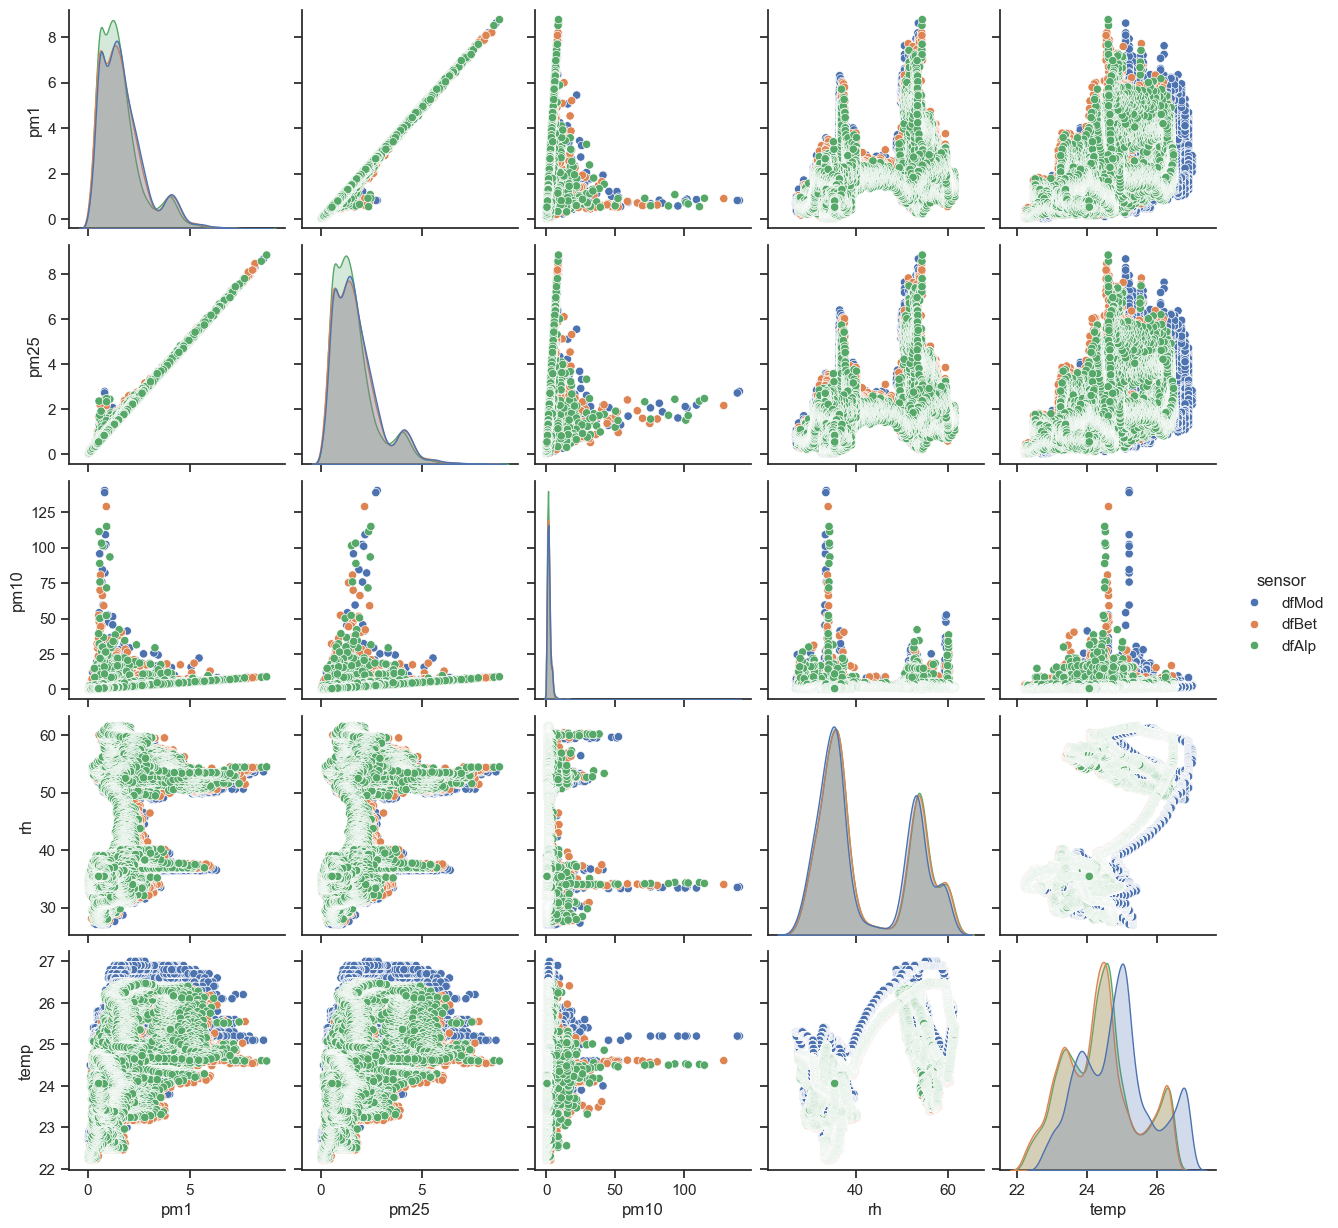

In [97]:
#Concept from the penguins regression file in class
columns_to_select = ['pm1', 'pm25', 'pm10', 'rh', 'temp', 'sensor']
# Add a 'sensor' column to each DataFrame
train_dfMod['sensor'] = 'dfMod'
train_dfBet['sensor'] = 'dfBet'
train_dfAlp['sensor'] = 'dfAlp'

# Concatenate the three datasets
df_concatenated = pd.concat([train_dfMod, train_dfBet, train_dfAlp])

# Resetting the index to create a single-index DataFrame
df_concatenated_reset = df_concatenated.reset_index()

# Use seaborn's pairplot to create scatterplot matrix
sns.set_theme(style="ticks")
sns.pairplot(df_concatenated_reset[columns_to_select], hue='sensor')

plt.show()

timestamp         sn    rh  temp  \
timestamp_local                                                          
2023-09-30 20:00:00+00:00  2023-10-01T00:00:35Z  MOD-00353  54.1  24.9   
2023-09-30 20:01:00+00:00  2023-10-01T00:01:35Z  MOD-00353  54.1  24.9   
2023-09-30 20:02:00+00:00  2023-10-01T00:02:35Z  MOD-00353  54.1  24.9   
2023-09-30 20:03:00+00:00  2023-10-01T00:03:35Z  MOD-00353  54.1  24.9   
2023-09-30 20:04:00+00:00  2023-10-01T00:04:35Z  MOD-00353  54.1  24.9   

                               lat       lon device_state    pm1   pm25  \
timestamp_local                                                           
2023-09-30 20:00:00+00:00  39.9559 -75.18598       ACTIVE  1.663  1.671   
2023-09-30 20:01:00+00:00  39.9559 -75.18598       ACTIVE  1.643  1.645   
2023-09-30 20:02:00+00:00  39.9559 -75.18598       ACTIVE  1.370  1.375   
2023-09-30 20:03:00+00:00  39.9559 -75.18598       ACTIVE  1.600  1.610   
2023-09-30 20:04:00+00:00  39.9559 -75.18598       ACTIVE  1.420  1.431   

                            pm10  ...  60 mean pm1  60 mean pm25  \
timestamp_local                   ...                              
2023-09-30 20:00:00+00:00  1.671  ...          NaN           NaN   
2023-09-30 20:01:00+00:00  1.645  ...          NaN           NaN   
2023-09-30 20:02:00+00:00  1.375  ...          NaN           NaN   
2023-09-30 20:03:00+00:00  1.610  ...          NaN           NaN   
2023-09-30 20:04:00+00:00  1.431  ...          NaN           NaN   

                           60 mean pm10  60 mean temp  sensor  id  \
timestamp_local                                                     
2023-09-30 20:00:00+00:00           NaN           NaN   dfMod NaN   
2023-09-30 20:01:00+00:00           NaN           NaN   dfMod NaN   
2023-09-30 20:02:00+00:00           NaN           NaN   dfMod NaN   
2023-09-30 20:03:00+00:00           NaN           NaN   dfMod NaN   
2023-09-30 20:04:00+00:00           NaN           NaN   dfMod NaN   

                           sample_pres  pm1_model_id  pm25_model_id  \
timestamp_local                                                       
2023-09-30 20:00:00+00:00          NaN           NaN            NaN   
2023-09-30 20:01:00+00:00          NaN           NaN            NaN   
2023-09-30 20:02:00+00:00          NaN           NaN            NaN   
2023-09-30 20:03:00+00:00          NaN           NaN            NaN   
2023-09-30 20:04:00+00:00          NaN           NaN            NaN   

                           pm10_model_id  
timestamp_local                           
2023-09-30 20:00:00+00:00            NaN  
2023-09-30 20:01:00+00:00            NaN  
2023-09-30 20:02:00+00:00            NaN  
2023-09-30 20:03:00+00:00            NaN  
2023-09-30 20:04:00+00:00            NaN  

[5 rows x 27 columns]

We can compute the correlation coefficient for each of the relevant columns

In [66]:
columns_to_select = ['pm1', 'pm25', 'pm10', 'rh', 'temp']
correlations_bet_mod = train_dfBet[columns_to_select].corrwith(train_dfMod[columns_to_select])
correlations_alp_mod = train_dfAlp[columns_to_select].corrwith(train_dfMod[columns_to_select])

print("Correlations between dfBet and dfMod:")
print(correlations_bet_mod)

print("\nCorrelations between dfAlp and dfMod:")
print(correlations_alp_mod)

Correlations between dfBet and dfMod:
pm1     0.969138
pm25    0.968789
pm10    0.730997
rh      0.999919
temp    0.998878
dtype: float64

Correlations between dfAlp and dfMod:
pm1     0.963401
pm25    0.963212
pm10    0.762527
rh      0.999899
temp    0.998542
dtype: float64


Obtain time series plots

In [72]:
parameters = [
    {'name': 'rh', 'label': 'Relative Humidity', 'unit': '%'},
    {'name': 'pm1', 'label': 'PM\u2081', 'unit': 'µg/m\u00b3'},
    {'name': 'pm25', 'label': 'PM\u2082.\u2085', 'unit': 'µg/m\u00b3'},
    {'name': 'pm10', 'label': 'PM\u2081\u2080', 'unit': 'µg/m\u00b3'},
    {'name': 'temp', 'label': 'Temperature', 'unit': '°C'}
]

Relative Humidity P-Value Alpha: 1.401573086709869e-07
Relative Humidity P-Value Beta: 8.557748903280419e-07
PM₁ P-Value Alpha: 2.719736226298462e-51
PM₁ P-Value Beta: 8.097760848647828e-07
PM₂.₅ P-Value Alpha: 9.849494170512791e-49
PM₂.₅ P-Value Beta: 1.5673137466827215e-05
PM₁₀ P-Value Alpha: 2.2170139363403661e-16
PM₁₀ P-Value Beta: 8.281707208895426e-06
Temperature P-Value Alpha: 0.0
Temperature P-Value Beta: 0.0


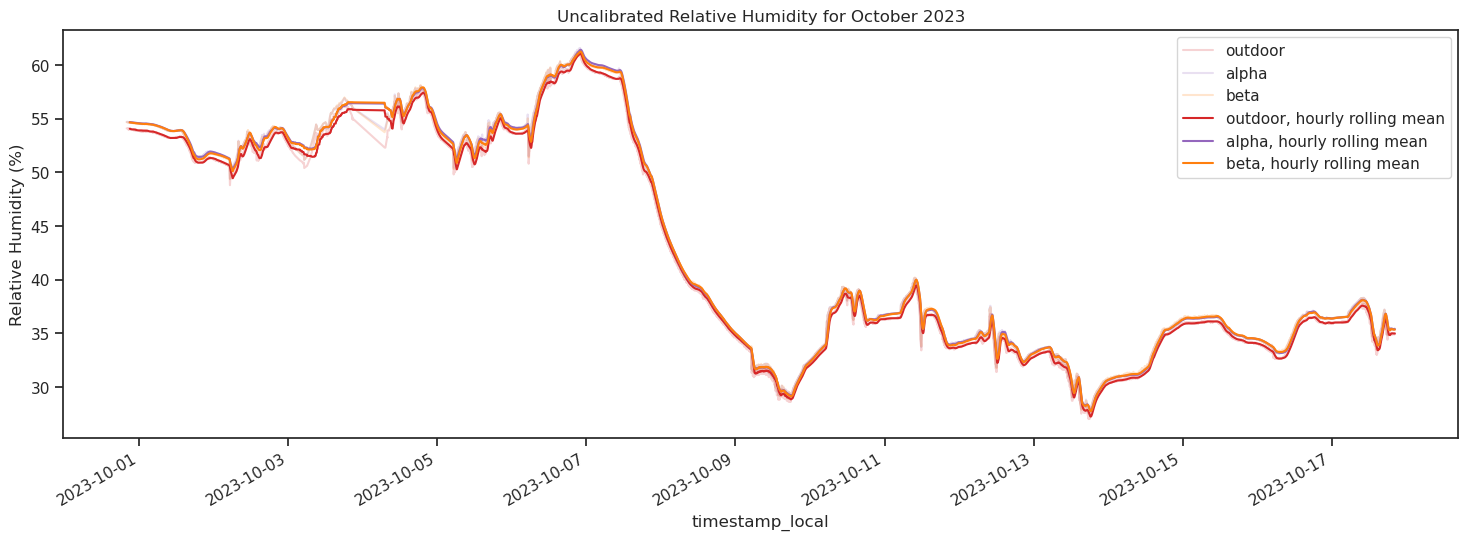

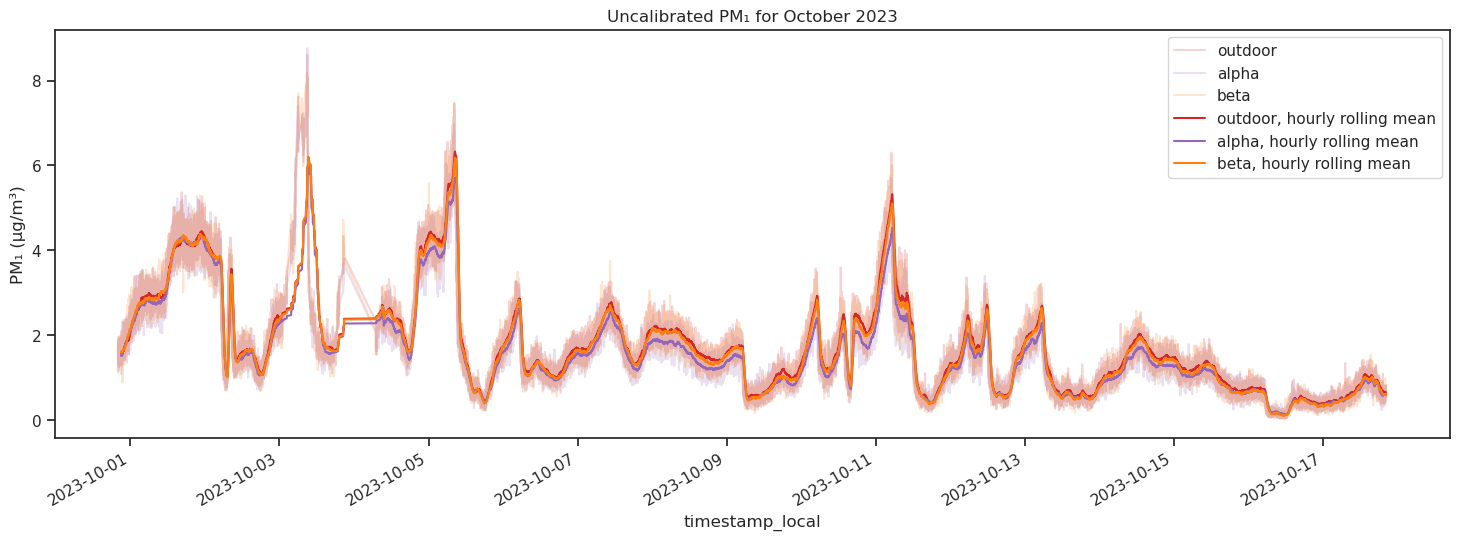

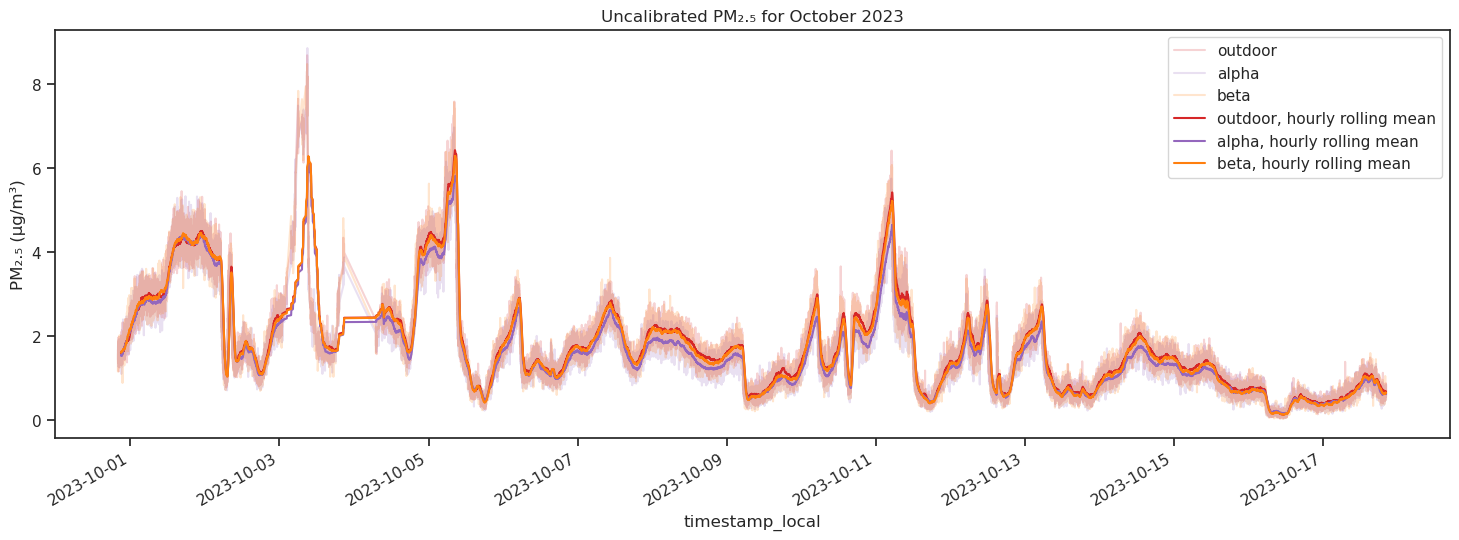

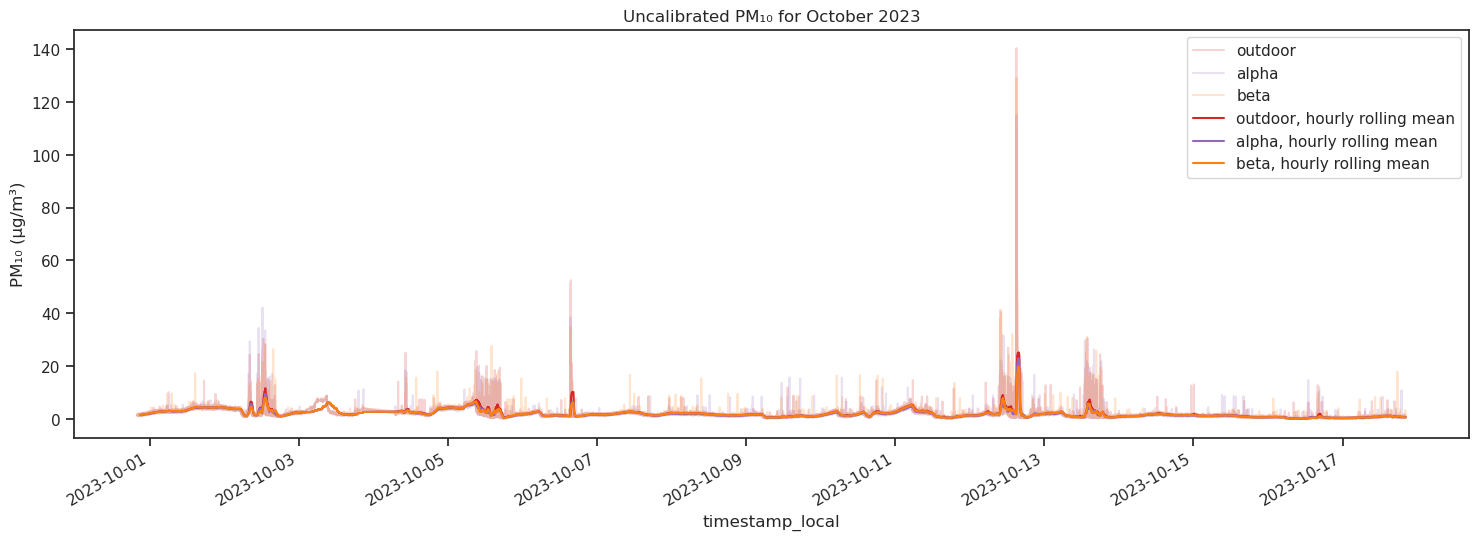

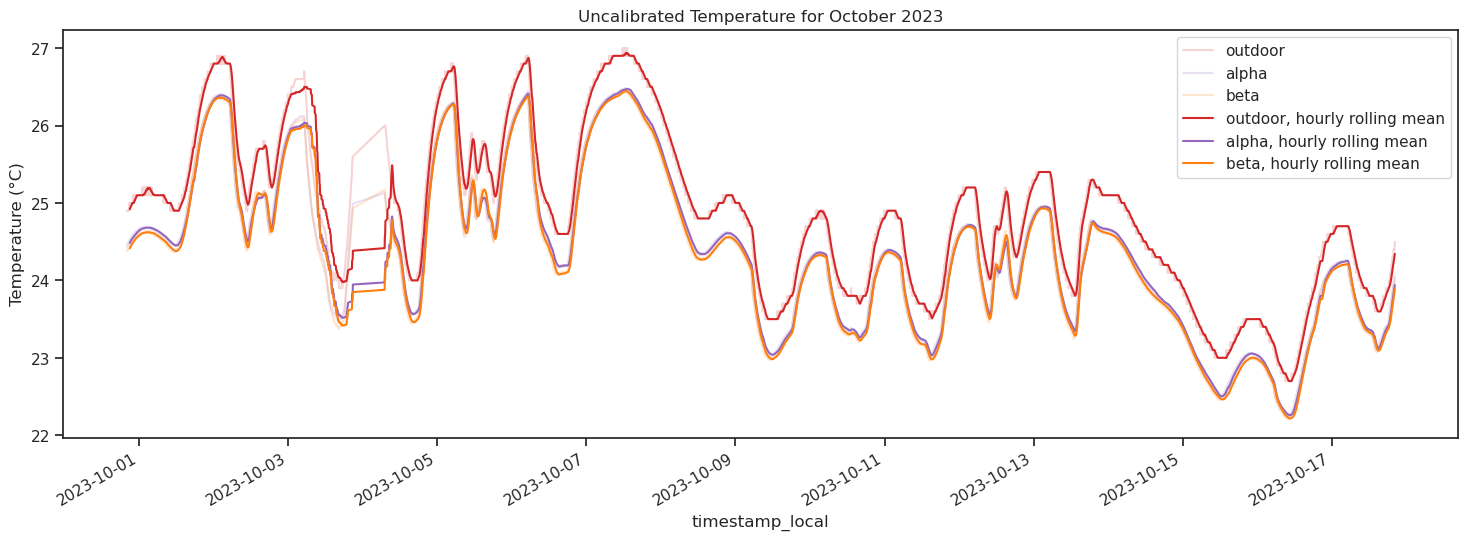

In [99]:
plt.rcParams['font.family'] = 'DejaVu Sans' #Choosing a font that supports unicode encoding
for parameter in parameters:
    train_dfMod[f'60 mean {parameter["name"]}']=train_dfMod[parameter['name']].rolling(60).mean() #hourly mean
    train_dfAlp[f'60 mean {parameter["name"]}']=train_dfAlp[parameter['name']].rolling(60).mean()
    train_dfBet[f'60 mean {parameter["name"]}']=train_dfBet[parameter['name']].rolling(60).mean()

    fig = plt.figure()
    ax = plt.subplot(111)
    plt.gcf().set_size_inches(18, 6)
    plt.title(f'Uncalibrated {parameter["label"]} for October 2023')
    plt.ylabel(f'{parameter["label"]} ({parameter["unit"]})')
    plt.xlabel('Time (days)')
    plt.grid(True)
    

   

    train_dfMod[parameter["name"]].plot(color='tab:red', label='outdoor', alpha=0.2)
    train_dfAlp[parameter["name"]].plot(color='tab:purple', label='alpha', alpha=0.2)
    train_dfBet[parameter["name"]].plot(color='tab:orange', label='beta', alpha=0.2)
    train_dfMod[f'60 mean {parameter["name"]}'].plot(color='tab:red', label='outdoor, hourly rolling mean')
    train_dfAlp[f'60 mean {parameter["name"]}'].plot(color='tab:purple', label='alpha, hourly rolling mean')
    train_dfBet[f'60 mean {parameter["name"]}'].plot(color='tab:orange', label='beta, hourly rolling mean')
    plt.legend()

    _, p_value_alpha = stats.ttest_ind(train_dfMod[parameter["name"]], train_dfAlp[parameter["name"]], equal_var=False)
    _, p_value_beta = stats.ttest_ind(train_dfMod[parameter["name"]], train_dfBet[parameter["name"]], equal_var=False)
    print(f"{parameter['label']} P-Value Alpha:", p_value_alpha)
    print(f"{parameter['label']} P-Value Beta:", p_value_beta)

### Simple linear Regression
Using a simple linear Regression for this problem. For simple linear regression, we want the outcome variable to be the outdoor sensor parameters, while the predictor variables will be the parameters for the alpha and beta sensor each.

Will use a simple linear function first. Later I can evaluate using sklearn linear model if needed (Should produce the same results)

In [103]:
#Using a simple function
def linear_func(x, a, b):
    return a * x + b 

# r squared calculation
def r_squared(y, y_fit):
    
    ss_residuals = np.sum((y - y_fit)**2)
    ss_total = np.sum((y - np.mean(y))**2)
    r2 = 1 - (ss_residuals / ss_total)
    return r2

a = 1.0106879402585163 b = 0.049276420530268594
r2 = 0.9997975230746101


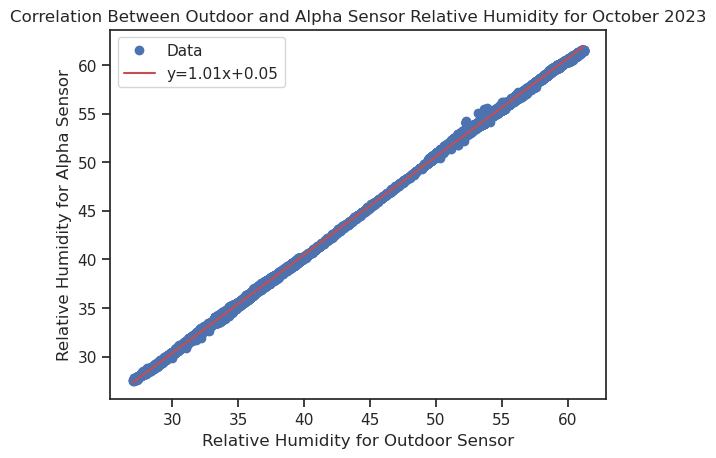

a = 1.0069121525489622 b = 0.17433396884264496
r2 = {'rh': 0.9998382774369867}


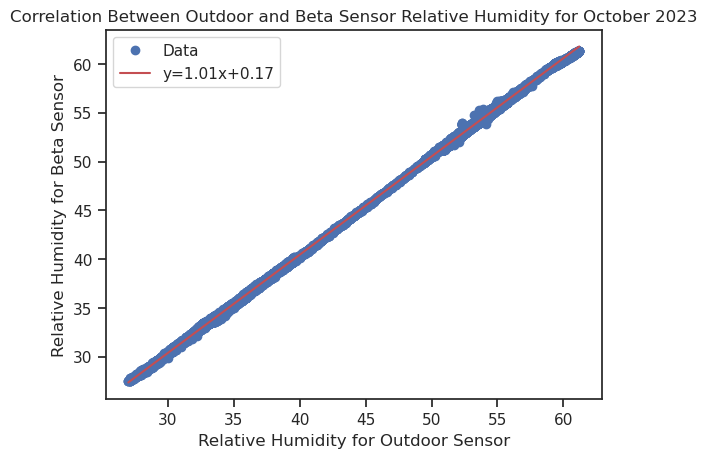

a = 0.9035605143662264 b = 0.008974501448893989
r2 = 0.928141367637648


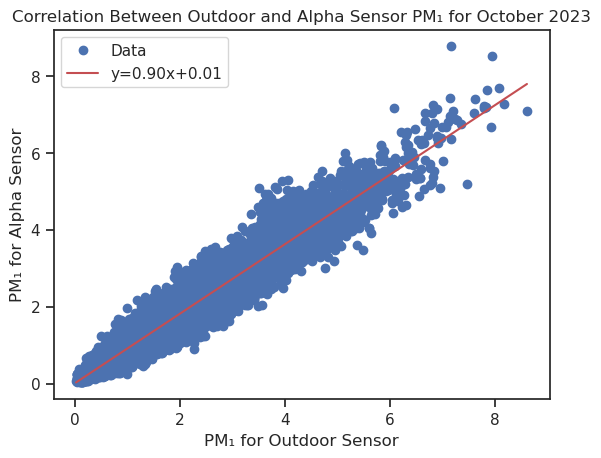

a = 0.9659768285879277 b = 0.005688433746007471
r2 = {'rh': 0.9998382774369867, 'pm1': 0.9392293961166269}


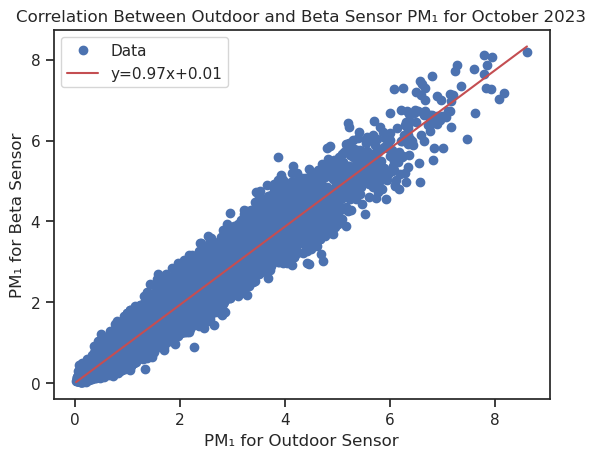

a = 0.9054918175833706 b = 0.012684021067343591
r2 = 0.9277766376432125


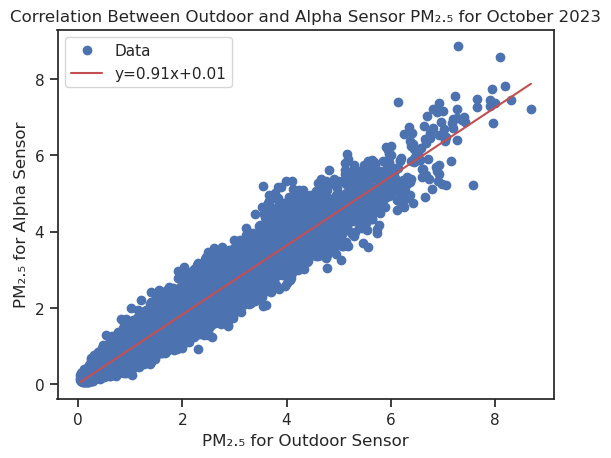

a = 0.9682722679401364 b = 0.009341658812951237
r2 = {'rh': 0.9998382774369867, 'pm1': 0.9392293961166269, 'pm25': 0.938553011719564}


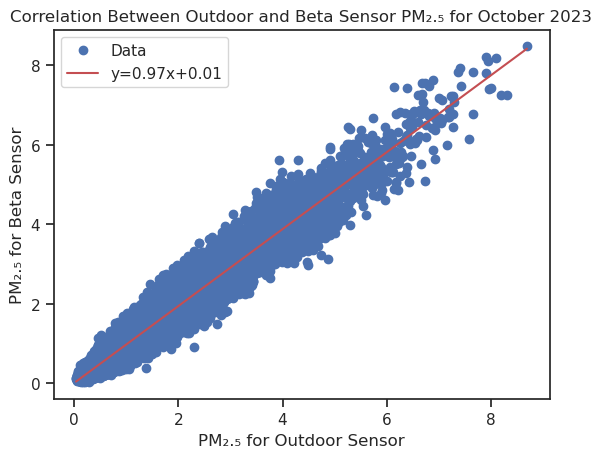

a = 0.6700797148008811 b = 0.484227218965304
r2 = 0.5814473327443683


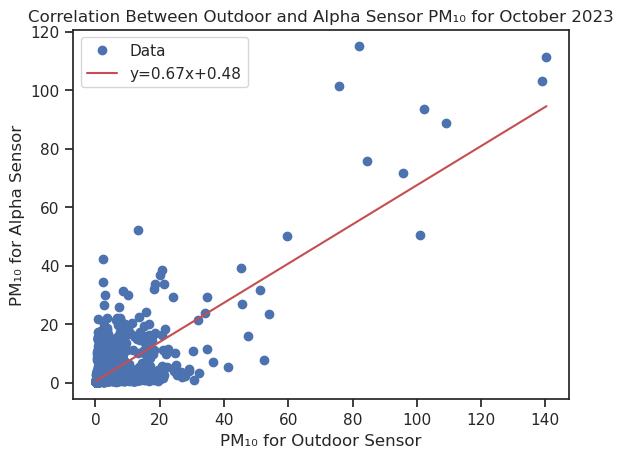

a = 0.5926373493506277 b = 0.7534847740135693
r2 = {'rh': 0.9998382774369867, 'pm1': 0.9392293961166269, 'pm25': 0.938553011719564, 'pm10': 0.5343559365270669}


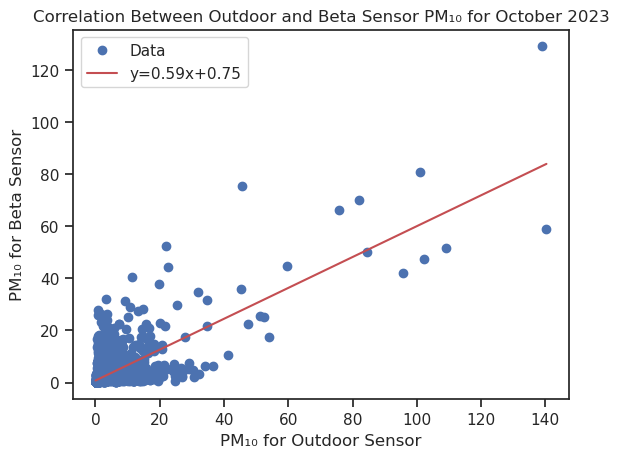

a = 0.992794734831688 b = -0.29572640204447065
r2 = 0.9970860588965952


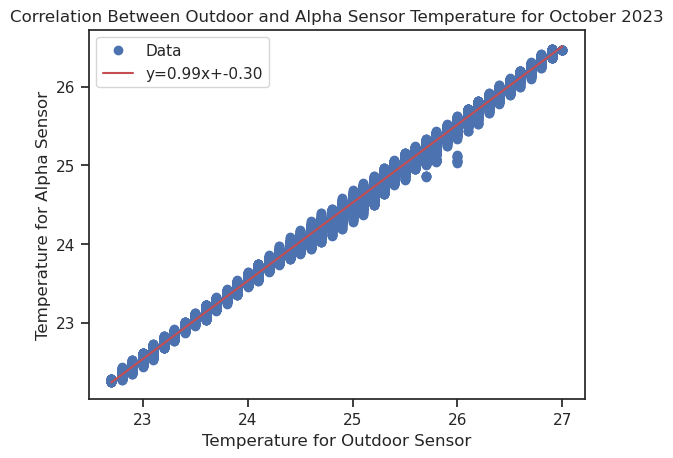

a = 1.0027129249802411 b = -0.5815740055696388
r2 = {'rh': 0.9998382774369867, 'pm1': 0.9392293961166269, 'pm25': 0.938553011719564, 'pm10': 0.5343559365270669, 'temp': 0.9977571915522829}


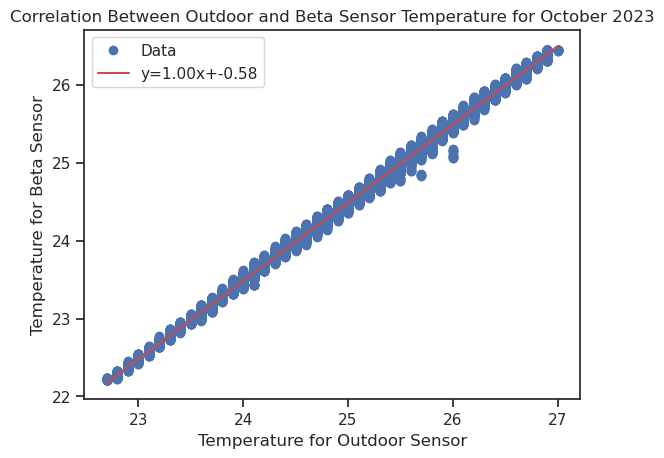

In [104]:
# Plotting the first figure
alpha_popt = {}
alpha_pcov = {}
alpha_r2 = {}
beta_popt = {}
beta_pcov = {}
beta_r2 = {}
for parameter in parameters:
    fig = plt.figure()
    ax1 = plt.subplot(111)

    x_fit = np.linspace(min(train_dfMod[parameter["name"]]), max(train_dfMod[parameter["name"]]), len(train_dfMod[parameter["name"]]))
    alpha_popt[parameter['name']], alpha_pcov[parameter["name"]] = curve_fit(linear_func, train_dfMod[parameter["name"]], train_dfAlp[parameter["name"]][:len(train_dfMod[parameter["name"]])])

    alpha_fit = linear_func(x_fit, *alpha_popt[parameter['name']])
    alpha_r2[parameter['name']] = r_squared(train_dfAlp[parameter["name"]].values[:len(train_dfMod[parameter["name"]])], linear_func(train_dfMod[parameter["name"]], *alpha_popt[parameter['name']]))

    print("a =", alpha_popt[parameter['name']][0], "b =", alpha_popt[parameter["name"]][1])
    print("r2 =", alpha_r2[parameter['name']])
    plt.plot(train_dfMod[parameter["name"]], train_dfAlp[parameter["name"]][:len(train_dfMod[parameter["name"]])], 'bo', label='Data')
    plt.plot(x_fit, alpha_fit, 'r-', label=f'y={alpha_popt[parameter["name"]][0]:.2f}x+{alpha_popt[parameter["name"]][1]:.2f}')
    plt.legend()
    plt.xlabel(f'{parameter["label"]} for Outdoor Sensor')
    plt.ylabel(f'{parameter["label"]} for Alpha Sensor')
    plt.title(f'Correlation Between Outdoor and Alpha Sensor {parameter["label"]} for October 2023')
    plt.show()

    train_dfAlp["new " +parameter['name']] = train_dfAlp[parameter["name"]] * 1 / alpha_popt[parameter['name']][0] - alpha_popt[parameter['name']][1] / alpha_popt[parameter['name']][0]

    beta_popt[parameter['name']], beta_pcov[parameter['name']] = curve_fit(linear_func, train_dfMod[parameter['name']], train_dfBet[parameter['name']][:len(train_dfMod[parameter['name']])])

    beta_fit = linear_func(x_fit, *beta_popt[parameter['name']])
    beta_r2[parameter["name"]] = r_squared(train_dfBet[parameter['name']].values[:len(train_dfMod[parameter['name']])], linear_func(train_dfMod[parameter['name']], *beta_popt[parameter['name']]))

    print("a =", beta_popt[parameter['name']][0], "b =", beta_popt[parameter['name']][1])
    print("r2 =",beta_r2)
    plt.plot(train_dfMod[parameter['name']], train_dfBet[parameter['name']][:len(train_dfMod[parameter['name']])], 'bo', label='Data')
    plt.plot(x_fit, beta_fit, 'r-', label=f'y={beta_popt[parameter["name"]][0]:.2f}x+{beta_popt[parameter["name"]][1]:.2f}')

    plt.legend()
    plt.xlabel(f'{parameter["label"]} for Outdoor Sensor')
    plt.ylabel(f'{parameter["label"]} for Beta Sensor')
    plt.title(f'Correlation Between Outdoor and Beta Sensor {parameter["label"]} for October 2023')
    plt.show()

    train_dfBet["new " + parameter["name"]] = train_dfBet[parameter["name"]] * 1 / beta_popt[parameter["name"]][0] - beta_popt[parameter["name"]][1] / beta_popt[parameter["name"]][0]

Print the r-squared values for clarity:

In [105]:
for parameter in parameters:
    print( 'Alpha ' + f'{parameter["label"]} r²: {alpha_r2[parameter["name"]]}')
    print( 'Beta '  + f'{parameter["label"]} r²: {beta_r2[parameter["name"]]}')

Alpha Relative Humidity r²: 0.9997975230746101
Beta Relative Humidity r²: 0.9998382774369867
Alpha PM₁ r²: 0.928141367637648
Beta PM₁ r²: 0.9392293961166269
Alpha PM₂.₅ r²: 0.9277766376432125
Beta PM₂.₅ r²: 0.938553011719564
Alpha PM₁₀ r²: 0.5814473327443683
Beta PM₁₀ r²: 0.5343559365270669
Alpha Temperature r²: 0.9970860588965952
Beta Temperature r²: 0.9977571915522829


Now to calibrate the training data, based on the model:

Relative Humidity P-Value Alpha: 0.9999999999785225
Relative Humidity P-Value Beta: 0.9999999999899247
PM₁ P-Value Alpha: 0.9999998299294592
PM₁ P-Value Beta: 0.9999999999833038
PM₂.₅ P-Value Alpha: 0.9999999888501667
PM₂.₅ P-Value Beta: 0.9999999997668576
PM₁₀ P-Value Alpha: 0.9999997539400625
PM₁₀ P-Value Beta: 0.9999998816318719
Temperature P-Value Alpha: 0.9999999999994156
Temperature P-Value Beta: 0.999999999939502


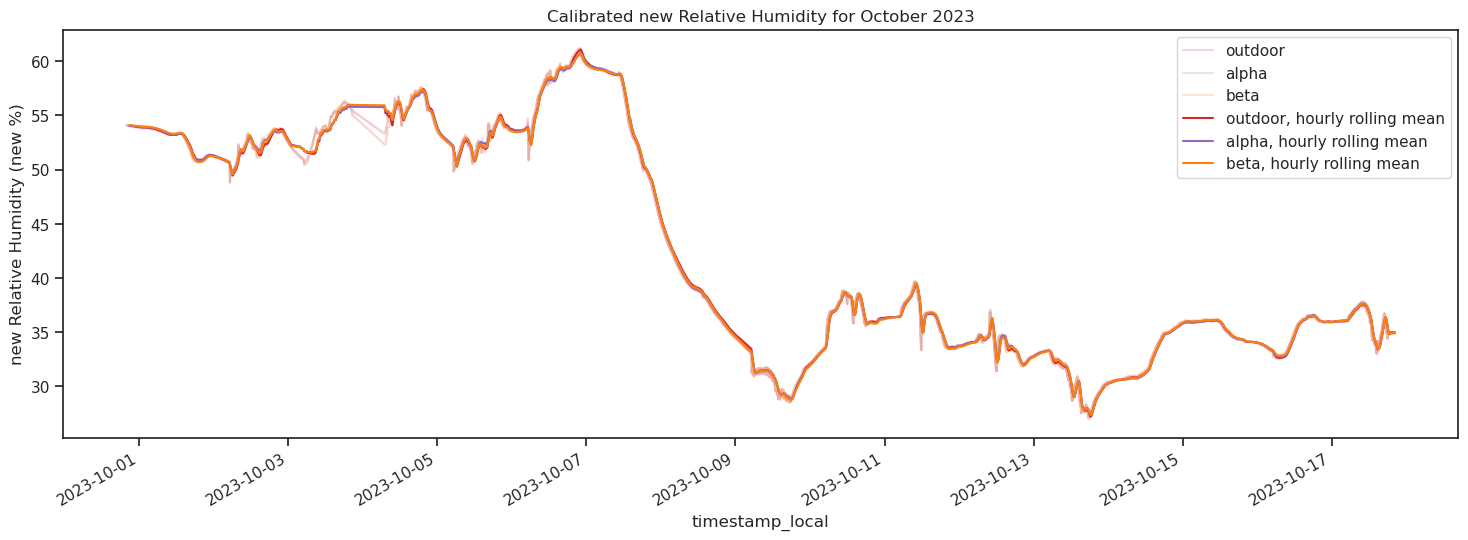

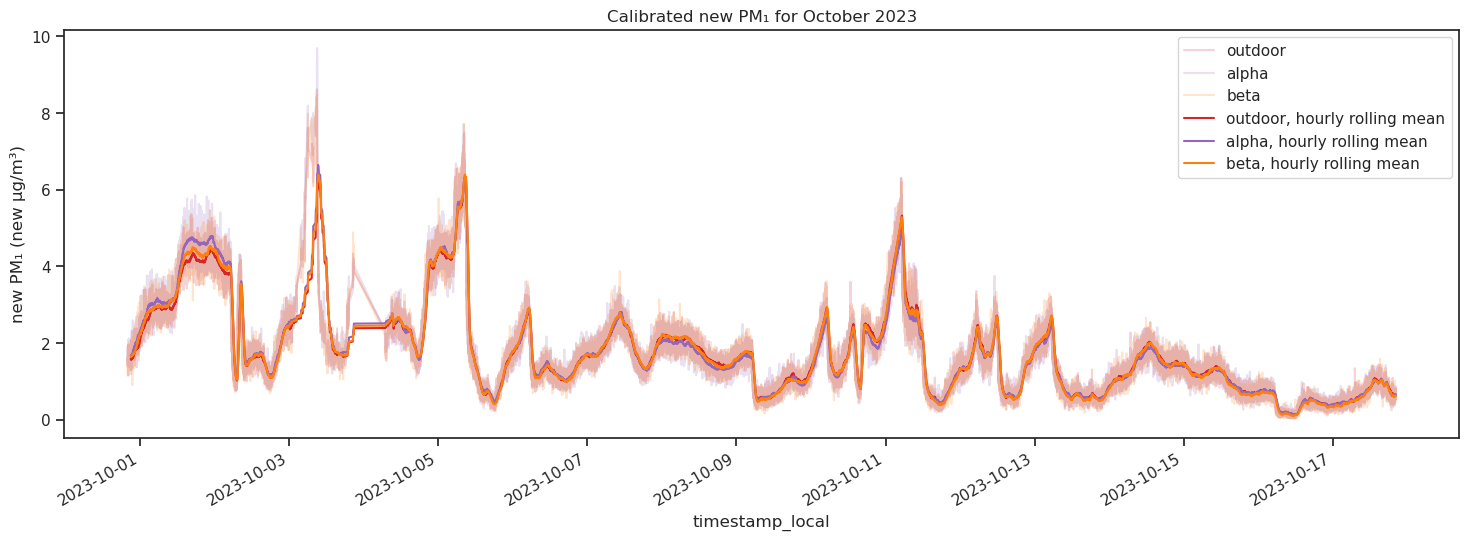

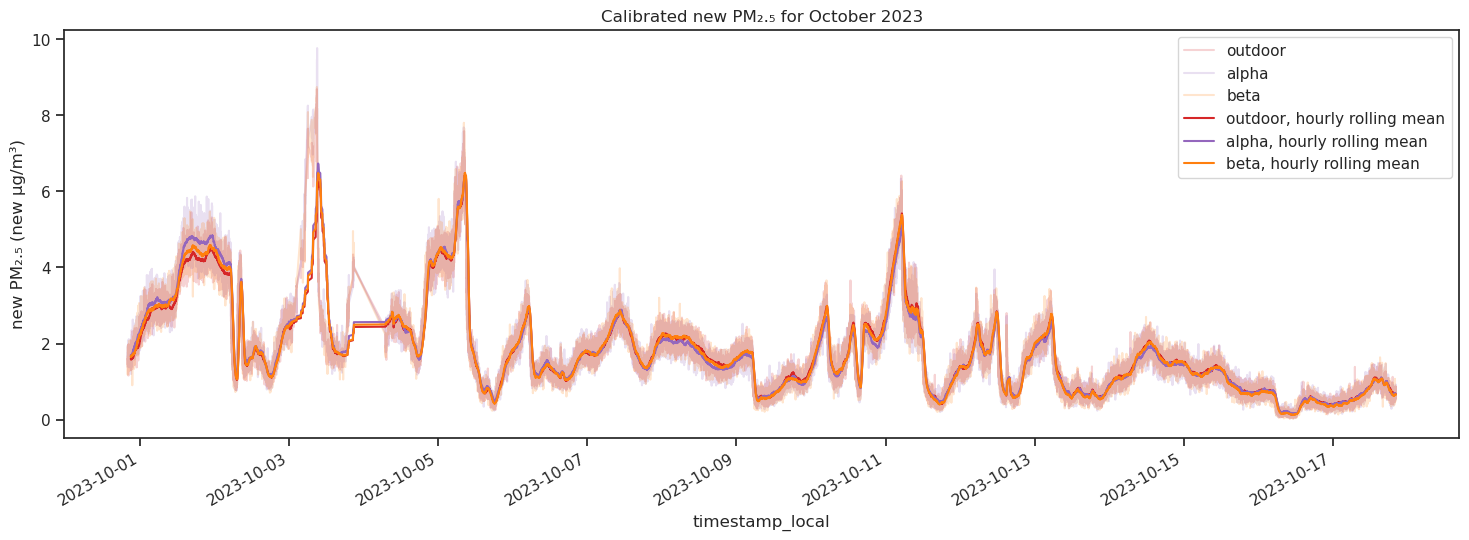

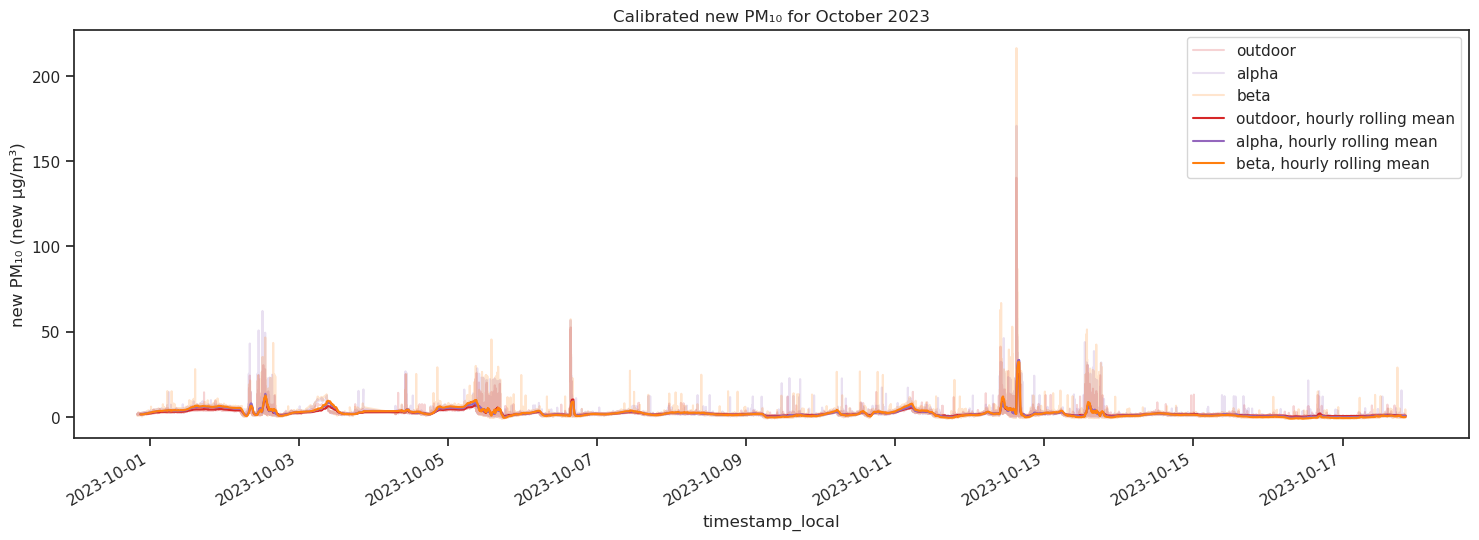

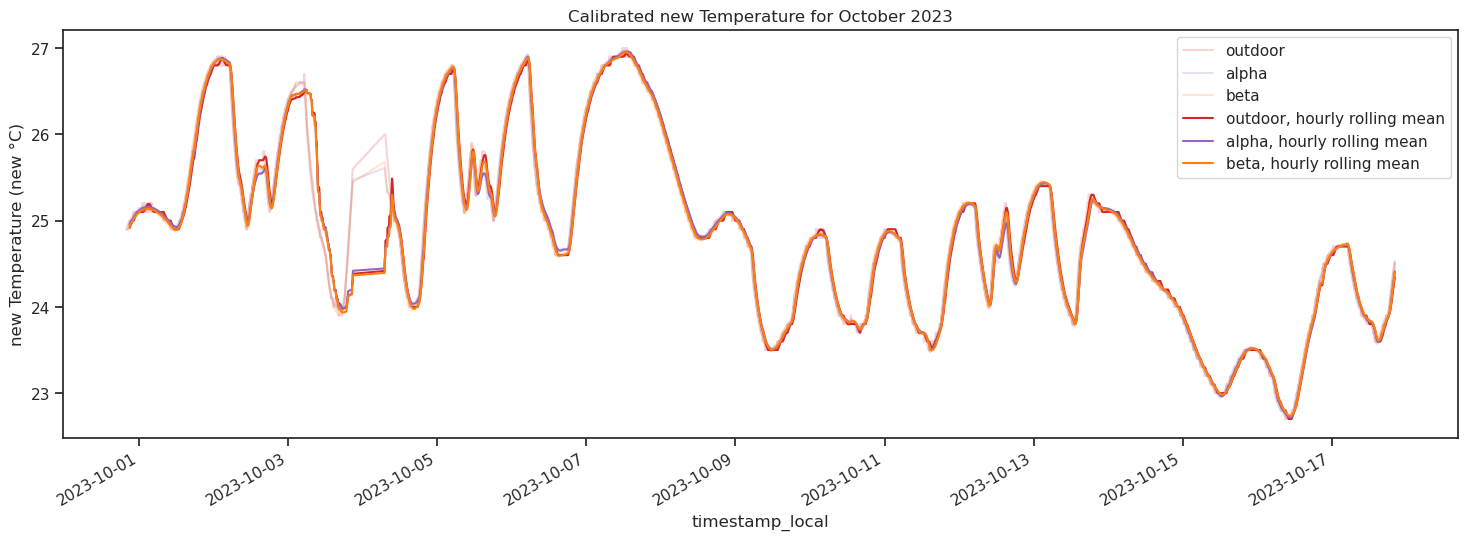

In [106]:
for parameter in parameters:
    train_dfMod[f'60 mean {"new " +parameter["name"]}']=train_dfMod[parameter['name']].rolling(60).mean()
    train_dfAlp[f'60 mean {"new " +parameter["name"]}']=train_dfAlp["new " +parameter['name']].rolling(60).mean()
    train_dfBet[f'60 mean {"new " +parameter["name"]}']=train_dfBet["new " +parameter['name']].rolling(60).mean()

    fig = plt.figure()
    ax = plt.subplot(111)
    plt.gcf().set_size_inches(18, 6)
    plt.title(f'Calibrated {"new " +parameter["label"]} for October 2023')
    plt.ylabel(f'{"new " +parameter["label"]} ({"new " +parameter["unit"]})')
    plt.xlabel('Time (days)')
    plt.grid(True)
    

   

    train_dfMod[parameter["name"]].plot(color='tab:red', label='outdoor', alpha=0.2)
    train_dfAlp["new " +parameter["name"]].plot(color='tab:purple', label='alpha', alpha=0.2)
    train_dfBet["new " +parameter["name"]].plot(color='tab:orange', label='beta', alpha=0.2)
    train_dfMod[f'60 mean {"new " +parameter["name"]}'].plot(color='tab:red', label='outdoor, hourly rolling mean')
    train_dfAlp[f'60 mean {"new " +parameter["name"]}'].plot(color='tab:purple', label='alpha, hourly rolling mean')
    train_dfBet[f'60 mean {"new " +parameter["name"]}'].plot(color='tab:orange', label='beta, hourly rolling mean')
    plt.legend()

    _, p_value_alpha = stats.ttest_ind(train_dfMod[parameter["name"]], train_dfAlp["new " +parameter["name"]], equal_var=False)
    _, p_value_beta = stats.ttest_ind(train_dfMod[parameter["name"]], train_dfBet["new " +parameter["name"]], equal_var=False)

    print(f"{parameter['label']} P-Value Alpha:", p_value_alpha)
    print(f"{parameter['label']} P-Value Beta:", p_value_beta)

Testing the model, showing the calibration on test data:

In [108]:
test_dfAlp = OR_dfAlp[test_slice]
test_dfBet = OR_dfBet[test_slice]
test_dfMod = OR_dfMod[test_slice]

for parameter in parameters:
    test_dfAlp["new " +parameter["name"]] = test_dfAlp[parameter["name"]]*(1/alpha_popt[parameter["name"]][0])-alpha_popt[parameter["name"]][1]/alpha_popt[parameter["name"]][0]
    test_dfBet["new " + parameter["name"]] = test_dfBet[parameter["name"]]*(1/beta_popt[parameter["name"]][0])-beta_popt[parameter["name"]][1]/beta_popt[parameter["name"]][0]

PM₁ P-Value Alpha: 4.3904015529516365e-06
PM₁ P-Value Beta: 0.08180089864504025
PM₂.₅ P-Value Alpha: 2.264099930127344e-06
PM₂.₅ P-Value Beta: 0.06224899867334791
PM₁₀ P-Value Alpha: 0.8967040709134199
PM₁₀ P-Value Beta: 0.21997416167439787


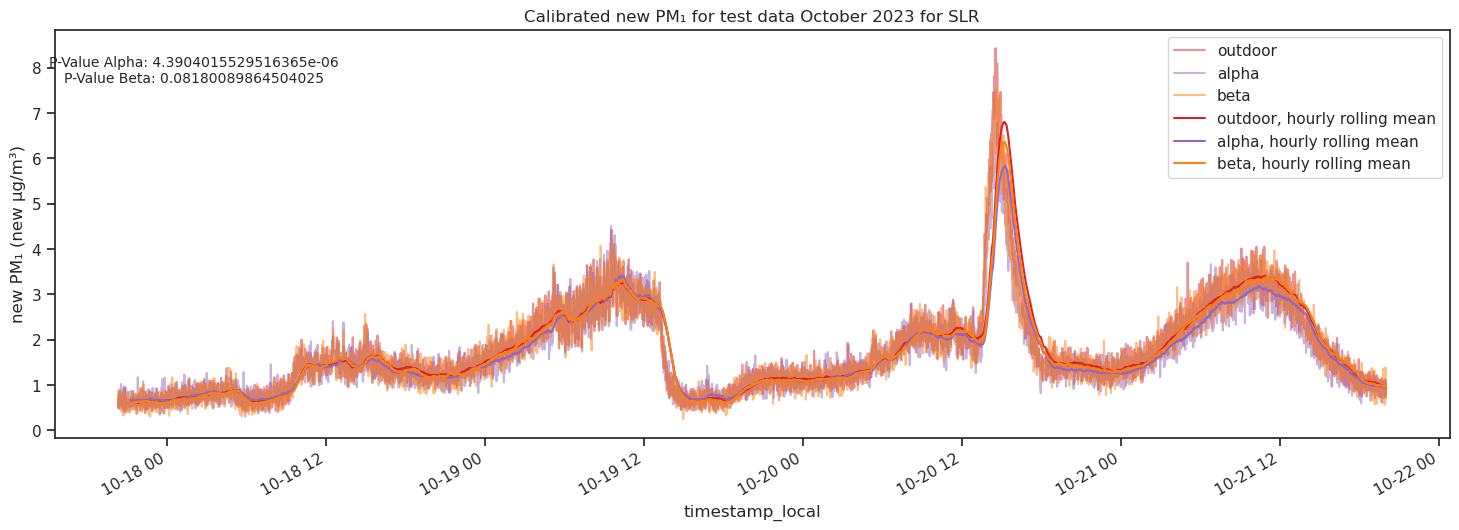

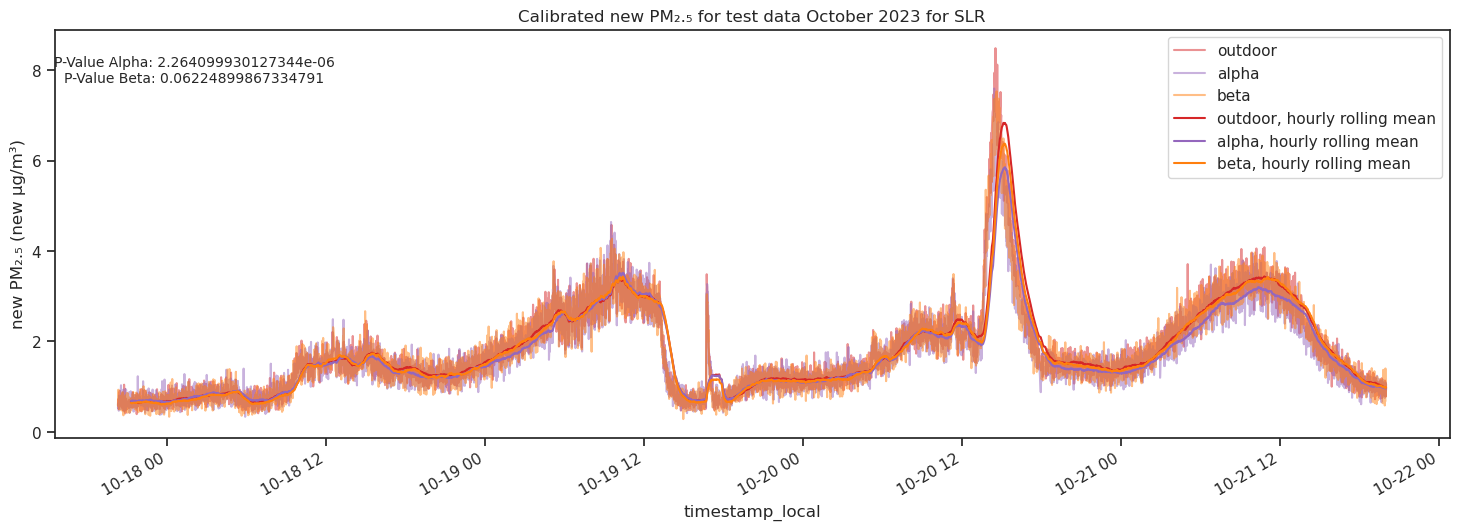

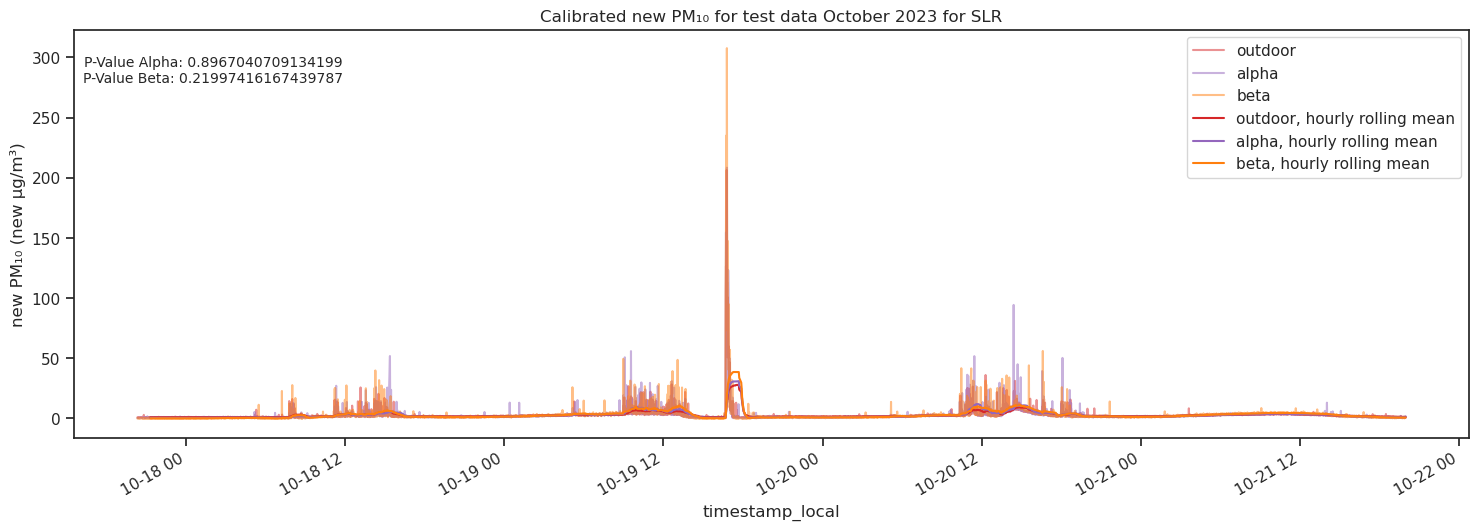

In [110]:
for  parameter in parameters[1:4]:
    test_dfMod[f'60 mean { parameter["name"]}']=test_dfMod[ parameter['name']].rolling(60).mean()
    test_dfAlp[f'60 mean {"new " + parameter["name"]}']=test_dfAlp["new " + parameter['name']].rolling(60).mean()
    test_dfBet[f'60 mean {"new " + parameter["name"]}']=test_dfBet["new " + parameter['name']].rolling(60).mean()
    fig = plt.figure()
    ax = plt.subplot(111)
    plt.gcf().set_size_inches(18, 6)
    plt.title(f'Calibrated {"new " + parameter["label"]} for test data October 2023 for SLR')
    plt.ylabel(f'{"new " + parameter["label"]} ({"new " + parameter["unit"]})')
    plt.xlabel('Time (days)')
    plt.grid(True)
    
    _, p_value_alpha = stats.ttest_ind(test_dfMod[ parameter["name"]], test_dfAlp["new " + parameter["name"]], equal_var=False)
    _, p_value_beta = stats.ttest_ind(test_dfMod[ parameter["name"]], test_dfBet["new " + parameter["name"]], equal_var=False)
    plt.text(0.1, 0.9, f'P-Value Alpha: {p_value_alpha}\nP-Value Beta: {p_value_beta}', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=10)

   

    test_dfMod[parameter["name"]].plot(color='tab:red', label='outdoor', alpha=0.5)
    test_dfAlp["new " + parameter["name"]].plot(color='tab:purple', label='alpha', alpha=0.5)
    test_dfBet["new " + parameter["name"]].plot(color='tab:orange', label='beta', alpha=0.5)
    test_dfMod[f'60 mean { parameter["name"]}'].plot(color='tab:red', label='outdoor, hourly rolling mean')
    test_dfAlp[f'60 mean {"new " + parameter["name"]}'].plot(color='tab:purple', label='alpha, hourly rolling mean')
    test_dfBet[f'60 mean {"new " + parameter["name"]}'].plot(color='tab:orange', label='beta, hourly rolling mean')
    plt.legend()

    print(f"{parameter['label']} P-Value Alpha:", p_value_alpha)
    print(f"{parameter['label']} P-Value Beta:", p_value_beta)

Obtain 1 to 1 line:

0.8944518344733653
0.9651949046111455
0.8961522076940854
0.9685779350758097
0.9552361376768681
1.0348172890276999


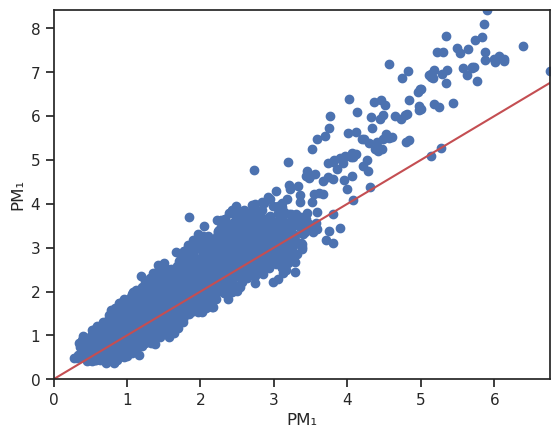

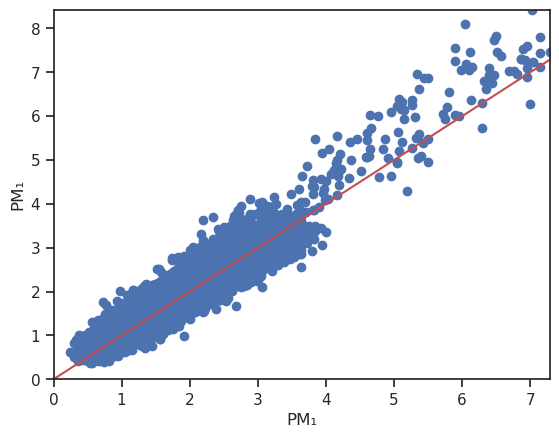

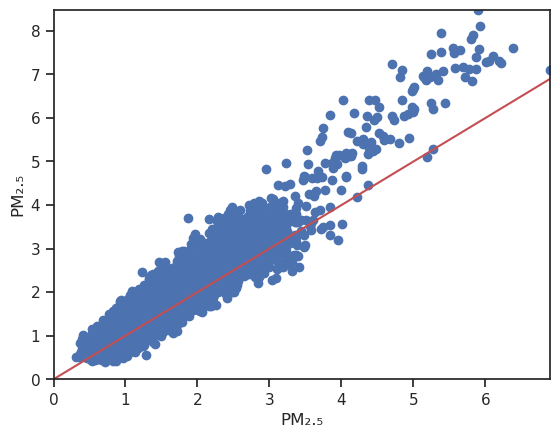

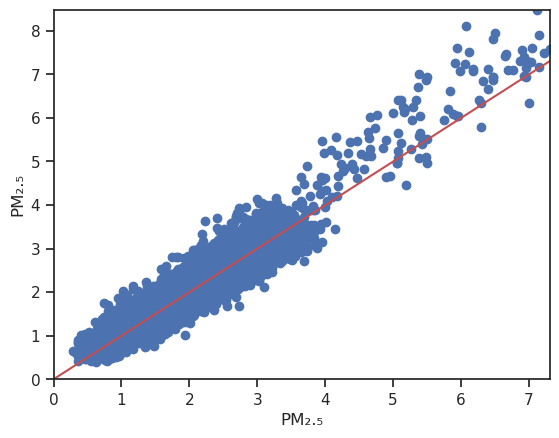

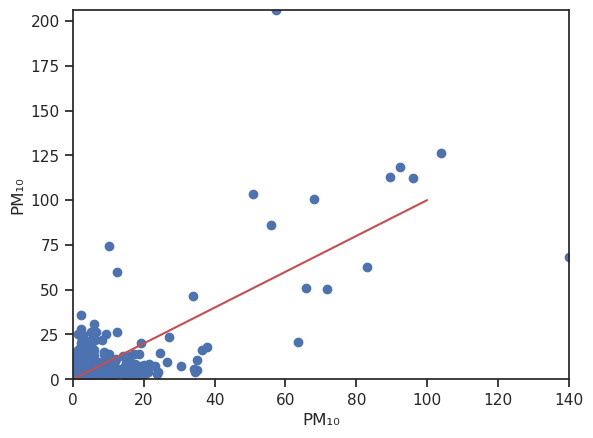

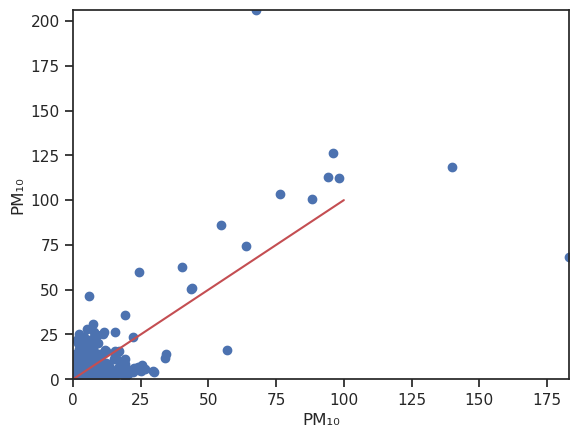

In [111]:
x = np.linspace(0, 100, 1000)
y = np.linspace(0, 100, 1000)

for parameter in parameters[1:4]:
    fig = plt.figure()
    ax = plt.subplot(111)
    
    plt.plot(test_dfAlp[parameter["name"]],test_dfMod[parameter["name"]][:len(test_dfAlp)], 'o', label='Original data')
    plt.plot(x, y, 'r', label='Fitted line')
    
    plt.ylim(0, max(test_dfMod[parameter["name"]][:len(test_dfAlp)]))
    plt.xlim(0, max(test_dfAlp[parameter["name"]]))
    plt.xlabel(parameter["label"])
    plt.ylabel(parameter["label"])

    fig = plt.figure()
    ax = plt.subplot(111)
    
    plt.plot(test_dfBet[parameter["name"]],test_dfMod[parameter["name"]][:len(test_dfBet)], 'o', label='Original data')
    plt.plot(x, y, 'r', label='Fitted line')

    plt.ylim(0, max(test_dfMod[parameter["name"]][:len(test_dfBet)]))
    plt.xlim(0, max(test_dfBet[parameter["name"]]))
    
    
    plt.xlabel(parameter["label"])
    plt.ylabel(parameter["label"])


    
    print(np.mean(test_dfAlp[parameter["name"]][:len(dfAlp)]/dfMod[parameter["name"]][:len(dfAlp)]))
    print(np.mean(test_dfBet[parameter["name"]][:len(dfBet)]/dfMod[parameter["name"]][:len(dfBet)]))

In [ ]:
# # Concatenate the alpha and beta sensor data
# dfAlpBet = pd.concat([dfAlp, dfBet], axis=1, keys=['alpha', 'beta'])

# # Extract the relevant columns
# X = dfAlpBet[['alpha_pm1', 'alpha_pm25', 'alpha_pm10', 'alpha_rh', 'alpha_temp',
#               'beta_pm1', 'beta_pm25', 'beta_pm10', 'beta_rh', 'beta_temp']]

# y = dfMod[['pm1', 'pm25', 'pm10', 'rh', 'temp']]  # Target variables from the outdoor sensor

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Create and fit the model
# model = LinearRegression()
# model.fit(X_train, y_train)

# # Make predictions on the test set
# predictions = model.predict(X_test)

# # Evaluate the model
# mse = mean_squared_error(y_test, predictions)
# print('Mean Squared Error:', mse)

# # Print the coefficients and intercept
# print('Intercept:', model.intercept_)
# print('Coefficients:', model.coef_)

### Multilinear Regression

We need to observe relationships or correlations between variables, and determine if it's statistically significant